In [3]:
import pandas as pd
import glob
import regex as re
import querygen as qg
# import pingouin as pg

import scipy.stats as stats

In [4]:
files = glob.glob("results_no_constraints/**/*.csv") #+ glob.glob("results/*.csv")
dfs = [pd.read_csv(f, index_col=0) for f in files]
files

['results_no_constraints/nvcluster_benedikt/eval_results_UniProt_oneshot_NousResearch-Hermes-3-Llama-3.1-70B-GGUF.csv',
 'results_no_constraints/nvcluster_benedikt/eval_results_Yago_oneshot_NousResearch-Hermes-3-Llama-3.1-70B-GGUF.csv',
 'results_no_constraints/warhammer/eval_results_DBpedia_oneshot_NousResearch-Hermes-3-Llama-3.2-3B-GGUF.csv',
 'results_no_constraints/warhammer/eval_results_UniProt_oneshot_bartowski-Qwen2.5-32B-Instruct-GGUF.csv',
 'results_no_constraints/warhammer/eval_results_Yago_oneshot_NousResearch-Hermes-3-Llama-3.2-3B-GGUF.csv',
 'results_no_constraints/warhammer/eval_results_UniProt_oneshot_NousResearch-Hermes-3-Llama-3.2-3B-GGUF.csv',
 'results_no_constraints/warhammer/eval_results_DBpedia_oneshot_NousResearch-Hermes-3-Llama-3.1-8B-GGUF.csv',
 'results_no_constraints/warhammer/eval_results_Yago_oneshot_NousResearch-Hermes-3-Llama-3.1-8B-GGUF.csv',
 'results_no_constraints/warhammer/eval_results_UniProt_oneshot_NousResearch-Hermes-3-Llama-3.1-8B-GGUF.csv',
 'r

In [5]:
dfs

[      f1_score  precision    recall  f1_score_rel  precision_rel  recall_rel  \
 0     0.500000        0.5  0.500000      1.000000       1.000000    1.000000   
 1     0.000000        0.0  0.000000      0.000000       0.000000    0.000000   
 2     1.000000        1.0  1.000000      1.000000       1.000000    1.000000   
 3     0.000000        0.0  0.000000      0.666667       0.500000    1.000000   
 4     0.000000        0.0  0.000000      0.000000       0.000000    0.000000   
 ...        ...        ...       ...           ...            ...         ...   
 1645  0.000000        0.0  0.000000      0.000000       0.000000    0.000000   
 1646  0.500000        0.5  0.500000      0.833333       0.833333    0.833333   
 1647  1.000000        1.0  1.000000      1.000000       1.000000    1.000000   
 1648  0.000000        0.0  0.000000      0.000000       0.000000    0.000000   
 1649  0.909091        1.0  0.833333      1.000000       1.000000    1.000000   
 
        ged  normed_ged   

In [6]:

def graph_from_erl(erl: qg.EnrichedEntitiesRelations):
    G = qg.nx.DiGraph()
    for node in erl.entities:
        G.add_node(node.identifier, label=node.type)
    for link in erl.relations:
        G.add_edge(
            link.entity,
            link.target,
            weight=link.link.instance_count,
            label=link.relation,
        )
    return G

In [7]:
model_map = {
    "NousResearch Hermes 3 Llama 3.2 3B": "Hermes 3 3B",
    "NousResearch Hermes 3 Llama 3.1 8B": "Hermes 3 8B",
    "NousResearch Hermes 3 Llama 3.1 70B": "Hermes 3 70B",
    "bartowski Mistral Small Instruct": "Mistral Small 24B",
    "bartowski Qwen2.5 Coder 32B": "Qwen2.5 Coder 32B",
    "bartowski Qwen2.5 32B Instruct": "Qwen2.5 Instruct 32B",
}
chosen_models = [
    "Hermes 3 3B",
    "Hermes 3 8B",
    "Hermes 3 70B",
    "Qwen2.5 Coder 32B",
    "Qwen2.5 Instruct 32B",
]

In [8]:
dfs_model_clean = []
for f, df in zip(files, dfs):
    # data=re.findall(r"results/eval_results_(\w+)_.*", f)[0]
    # prompt_type=re.findall(r"results/eval_results_(\w+)_.*", f)[0]
    model = re.findall(r"eval_results_\w+_(.+)\.csv", f)[0]
    # df['prompt_type'] = prompt_type
    df["model"] = model.replace("_", " ").replace("-", " ")
    df["model"] = df["model"].apply(
        lambda x: next((v for k, v in model_map.items() if x.startswith(k)), x)
    )
    df = df[df["model"].isin(chosen_models)]
    dfs_model_clean.append(df)
df = pd.concat(dfs_model_clean)
df

,f1_score,precision,recall,f1_score_rel,precision_rel,recall_rel,ged,normed_ged,response,model,cfg_name,zeroshot,stage,generator,n_nodes,seed,erl,erl_loaded
0,0.5,0.5,0.5,1.000000,1.000000,1.000000,1.0,0.666667,The reviewed protein records are encoded in th...,Hermes 3 70B,UniProt,False,raw,llama,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.0,0.000000,The reviewed protein records are encoded in th...,Hermes 3 70B,UniProt,False,constrained,llama,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...
2,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.0,1.000000,The reviewed protein records are encoded in th...,Hermes 3 70B,UniProt,False,aligned,llama,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...
3,0.0,0.0,0.0,0.666667,0.500000,1.000000,4.0,0.200000,a Reviewed protein (records) has a encoded in ...,Hermes 3 70B,UniProt,False,raw,templated,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,5.0,0.000000,a Reviewed protein (records) has a encoded in ...,Hermes 3 70B,UniProt,False,constrained,templated,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,0.0,0.0,0.0,0.000000,0.000000,0.000000,18.0,-0.200000,"A person has multiple career stations, a place...",Qwen2.5 Coder 32B,DBpedia,False,constrained,llama,7,104,"{""relations"":[{""entity"":""person"",""relation"":""c...","relations=[EnrichedRelation(entity='person', r..."
2378,1.0,1.0,1.0,0.666667,0.666667,0.666667,5.0,0.666667,"A person has multiple career stations, a place...",Qwen2.5 Coder 32B,DBpedia,False,aligned,llama,7,104,"{""relations"":[{""entity"":""person"",""relation"":""c...","relations=[EnrichedRelation(entity='person', r..."
2379,1.0,1.0,1.0,1.000000,1.000000,1.000000,9.0,0.437500,a person has a career station with career stat...,Qwen2.5 Coder 32B,DBpedia,False,raw,templated,7,104,"{""relations"":[{""entity"":""person"",""relation"":""c...","relations=[EnrichedRelation(entity='person', r..."
2380,0.0,0.0,0.0,0.000000,0.000000,0.000000,21.0,-0.235294,a person has a career station with career stat...,Qwen2.5 Coder 32B,DBpedia,False,constrained,templated,7,104,"{""relations"":[{""entity"":""person"",""relation"":""c...","relations=[EnrichedRelation(entity='person', r..."


In [9]:
df['n_nodes']= df['n_nodes'].astype(int)
chosen_k=[2,3,5,7]
df = df[df['n_nodes'].isin(chosen_k)]

In [10]:
df["model"].unique()

array(['Hermes 3 70B', 'Hermes 3 3B', 'Qwen2.5 Instruct 32B',
       'Hermes 3 8B', 'Qwen2.5 Coder 32B'], dtype=object)

In [11]:
df["prompt_type"] = df["zeroshot"].apply(lambda x: "zero shot" if x else "one shot")
df.drop(columns=["zeroshot"], inplace=True)
df

/var/folders/w0/5b7f2srd2sb_56zjv17vqnym0000gn/T/ipykernel_33507/3427193238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prompt_type"] = df["zeroshot"].apply(lambda x: "zero shot" if x else "one shot")
/var/folders/w0/5b7f2srd2sb_56zjv17vqnym0000gn/T/ipykernel_33507/3427193238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["zeroshot"], inplace=True)


,f1_score,precision,recall,f1_score_rel,precision_rel,recall_rel,ged,normed_ged,response,model,cfg_name,stage,generator,n_nodes,seed,erl,erl_loaded,prompt_type
0,0.5,0.5,0.5,1.000000,1.000000,1.000000,1.0,0.666667,The reviewed protein records are encoded in th...,Hermes 3 70B,UniProt,raw,llama,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...,one shot
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.0,0.000000,The reviewed protein records are encoded in th...,Hermes 3 70B,UniProt,constrained,llama,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...,one shot
2,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.0,1.000000,The reviewed protein records are encoded in th...,Hermes 3 70B,UniProt,aligned,llama,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...,one shot
3,0.0,0.0,0.0,0.666667,0.500000,1.000000,4.0,0.200000,a Reviewed protein (records) has a encoded in ...,Hermes 3 70B,UniProt,raw,templated,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...,one shot
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,5.0,0.000000,a Reviewed protein (records) has a encoded in ...,Hermes 3 70B,UniProt,constrained,templated,2,0,"{""relations"":[{""entity"":""Reviewed protein (rec...",relations=[EnrichedRelation(entity='Reviewed p...,one shot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,0.0,0.0,0.0,0.000000,0.000000,0.000000,18.0,-0.200000,"A person has multiple career stations, a place...",Qwen2.5 Coder 32B,DBpedia,constrained,llama,7,104,"{""relations"":[{""entity"":""person"",""relation"":""c...","relations=[EnrichedRelation(entity='person', r...",one shot
2378,1.0,1.0,1.0,0.666667,0.666667,0.666667,5.0,0.666667,"A person has multiple career stations, a place...",Qwen2.5 Coder 32B,DBpedia,aligned,llama,7,104,"{""relations"":[{""entity"":""person"",""relation"":""c...","relations=[EnrichedRelation(entity='person', r...",one shot
2379,1.0,1.0,1.0,1.000000,1.000000,1.000000,9.0,0.437500,a person has a career station with career stat...,Qwen2.5 Coder 32B,DBpedia,raw,templated,7,104,"{""relations"":[{""entity"":""person"",""relation"":""c...","relations=[EnrichedRelation(entity='person', r...",one shot
2380,0.0,0.0,0.0,0.000000,0.000000,0.000000,21.0,-0.235294,a person has a career station with career stat...,Qwen2.5 Coder 32B,DBpedia,constrained,templated,7,104,"{""relations"":[{""entity"":""person"",""relation"":""c...","relations=[EnrichedRelation(entity='person', r...",one shot


In [12]:
df_clean = df.dropna()
df_clean.describe()

,f1_score,precision,recall,f1_score_rel,precision_rel,recall_rel,ged,normed_ged,n_nodes,seed
count,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000
mean,0.347401,0.359539,0.343310,0.368615,0.375446,0.371395,10.453199,0.261304,3.575848,59.141098
std,0.403262,0.415012,0.403096,0.442418,0.450438,0.448153,35.048290,0.349006,1.700157,37.260031
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.384615,2.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,27.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.125000,3.000000,57.000000
75%,0.727273,0.750000,0.666667,1.000000,1.000000,1.000000,7.000000,0.500000,5.000000,91.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,410.000000,1.000000,7.000000,157.000000


In [13]:
df["erl_loaded"] = df["erl"].apply(qg.EnrichedEntitiesRelations.model_validate_json)
# df["response_loaded"] = df["response"].apply(lambda x: qg.EnrichedEntitiesRelations.model_validate_json(x) if isinstance(x, str) else None)
df["erl_graph"] = df["erl_loaded"].apply(graph_from_erl)
# df["response_graph"] = df["response"].apply(lambda x: graph_from_erl if x is not None else None)

/var/folders/w0/5b7f2srd2sb_56zjv17vqnym0000gn/T/ipykernel_33507/3529876243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["erl_loaded"] = df["erl"].apply(qg.EnrichedEntitiesRelations.model_validate_json)
/var/folders/w0/5b7f2srd2sb_56zjv17vqnym0000gn/T/ipykernel_33507/3529876243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["erl_graph"] = df["erl_loaded"].apply(graph_from_erl)


In [14]:
# df["normed_ged"] = 1 - df["ged"] / df["erl_graph"].apply(
#     lambda x: (len(x.nodes) + len(x.nodes))
# )

In [15]:
df_clean["generator"].unique(), df_clean["model"].unique()

(array(['llama', 'templated', 'human'], dtype=object),
 array(['Hermes 3 70B', 'Hermes 3 3B', 'Qwen2.5 Instruct 32B',
        'Hermes 3 8B', 'Qwen2.5 Coder 32B'], dtype=object))

In [16]:
means = df_clean.groupby(
    ["n_nodes", "prompt_type", "stage", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].mean()
stds= df_clean.groupby(
    ["n_nodes", "prompt_type", "stage", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].std()
counts = df_clean.groupby(
    ["n_nodes", "stage", "prompt_type", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].count()
means

f1_score  \
n_nodes prompt_type stage   model                generator cfg_name             
2       one shot    aligned Hermes 3 3B          llama     BTO       0.227174   
                                                           DBpedia   0.654400   
                                                           UniProt   0.579592   
                                                           Yago      0.569551   
                                                 templated BTO       0.402703   
...                                                                       ...   
7       one shot    raw     Qwen2.5 Instruct 32B llama     Yago      0.650723   
                                                 templated BTO       0.000000   
                                                           DBpedia   0.697767   
                                                           UniProt   0.615951   
                                                           Yago      0.797697   

                                                                     normed_ged  
n_nodes prompt_type stage   model                generator cfg_name              
2       one shot    aligned Hermes 3 3B          llama     BTO         0.386051  
                                                           DBpedia     0.545953  
                                                           UniProt     0.585714  
                                                           Yago        0.607849  
                                                 templated BTO         0.546203  
...                                                                         ...  
7       one shot    raw     Qwen2.5 Instruct 32B llama     Yago        0.314498  
                                                 templated BTO         0.461538  
                                                           DBpedia     0.518341  
                                                           UniProt     0.400733  
                                                           Yago        0.852362  

[507 rows x 2 columns]

In [17]:
stds

f1_score  \
n_nodes prompt_type stage   model                generator cfg_name             
2       one shot    aligned Hermes 3 3B          llama     BTO       0.365580   
                                                           DBpedia   0.381178   
                                                           UniProt   0.368323   
                                                           Yago      0.342215   
                                                 templated BTO       0.468737   
...                                                                       ...   
7       one shot    raw     Qwen2.5 Instruct 32B llama     Yago      0.181191   
                                                 templated BTO            NaN   
                                                           DBpedia   0.339161   
                                                           UniProt   0.329746   
                                                           Yago      0.263342   

                                                                     normed_ged  
n_nodes prompt_type stage   model                generator cfg_name              
2       one shot    aligned Hermes 3 3B          llama     BTO         0.270635  
                                                           DBpedia     0.372517  
                                                           UniProt     0.337237  
                                                           Yago        0.343365  
                                                 templated BTO         0.365474  
...                                                                         ...  
7       one shot    raw     Qwen2.5 Instruct 32B llama     Yago        0.136897  
                                                 templated BTO              NaN  
                                                           DBpedia     0.311486  
                                                           UniProt     0.339747  
                                                           Yago        0.189316  

[507 rows x 2 columns]

In [18]:
counts

f1_score  \
n_nodes stage   prompt_type model                generator cfg_name             
2       aligned one shot    Hermes 3 3B          llama     BTO             92   
                                                           DBpedia        125   
                                                           UniProt         98   
                                                           Yago           104   
                                                 templated BTO             37   
...                                                                       ...   
7       raw     one shot    Qwen2.5 Instruct 32B llama     Yago            19   
                                                 templated BTO              1   
                                                           DBpedia         82   
                                                           UniProt          7   
                                                           Yago            19   

                                                                     normed_ged  
n_nodes stage   prompt_type model                generator cfg_name              
2       aligned one shot    Hermes 3 3B          llama     BTO               92  
                                                           DBpedia          125  
                                                           UniProt           98  
                                                           Yago             104  
                                                 templated BTO               37  
...                                                                         ...  
7       raw     one shot    Qwen2.5 Instruct 32B llama     Yago              19  
                                                 templated BTO                1  
                                                           DBpedia           82  
                                                           UniProt            7  
                                                           Yago              19  

[507 rows x 2 columns]

In [19]:
column_map = {
    "f1_score": "$F_{1,node}$",
    "f1_score_rel": "$F_{1,rel.}$ ",
    "normed_ged": "$GED_{s}$",
    "stage": "Stage",
    "prompt_type": "Prompt Type",
    "model": "Version \\& Size",
    "n_nodes": "$k$",
    "generator": "Query Origin",
}

## Compare Query Origins on DBpedia with 8B model

In [20]:
query_gen_compare = df_clean[
    df_clean["model"].str.contains("3B")
    & df_clean["cfg_name"].str.contains("DBpedia")
    & df_clean["prompt_type"].str.contains("one shot")
    & ~df_clean["stage"].str.contains("constrained")
    & (df_clean["n_nodes"] < 6)
    & (df_clean["n_nodes"] > 2)
]
grouped_query_gen_compare = query_gen_compare.groupby(
    ["n_nodes", "generator", "stage"]
)[["f1_score", "normed_ged"]]
grouped_query_gen_compare_mean = grouped_query_gen_compare.mean()
grouped_query_gen_compare_std = grouped_query_gen_compare.std()
grouped_query_gen_compare_percentiles = grouped_query_gen_compare.quantile(
    [0.25, 0.5, 0.75]
)
grouped_query_gen_compare_mean = grouped_query_gen_compare_mean.rename(
    columns=column_map
).rename_axis(
    [column_map["n_nodes"], column_map["generator"], column_map["stage"]], axis=0
)
grouped_query_gen_compare_mean = grouped_query_gen_compare_mean.rename(
    columns={k: f"Mean {k}" for k in grouped_query_gen_compare_mean.columns}
)

# grouped_query_gen_compare_mean["TOST"] = ""
for n_nodes in query_gen_compare["n_nodes"].unique():
    for origin in ["llama", "templated"]:
        
        a = query_gen_compare[
            (query_gen_compare["generator"] == origin)
            & (query_gen_compare["n_nodes"] == n_nodes)
            & (query_gen_compare["stage"] == "aligned")
        ]["f1_score"].to_numpy()
        b = query_gen_compare[
            (query_gen_compare["generator"] == "human")
            & (query_gen_compare["n_nodes"] == n_nodes)
            & (query_gen_compare["stage"] == "aligned")
        ]["f1_score"].to_numpy()
        
        # Bayesian t-test (Welch's version)

        bound = 0.2
        # Unpaired two-sample t-test
        _, p_greater = stats.ttest_ind(a + bound, b, alternative="greater")
        _, p_less = stats.ttest_ind(a - bound, b, alternative="less")
        # Choose the maximum p-value
        pval = max(p_less, p_greater)
        test = stats.ttest_ind(a, b, equal_var=False)
        # result = pg.bayesfactor_ttest(t=test.statistic, nx=a.shape[0], ny=a.shape[0], alternative="two-sided")
        # # print(f"TOST: n_nodes = {n_nodes}, origin = {origin}, p = {pval:.3f}")
        # print("--- n_nodes =", n_nodes, "and origin =", origin)
        # print(f"TOST: p = {pval:5.3f} (\delta = {bound})")
        # print(f"t-test (means): {test.statistic:.3f}, p-value: {test.pvalue:.3f}")
        # print(f"Bayes Factor: {1/result:.3f} (H1/H0)")
        # print(f"t-statistic: {test.statistic:.3f}, p-value: {test.pvalue:.3f}")
        # grouped_query_gen_compare_mean.loc[
        #     (n_nodes, origin, "aligned"), "TOST"
        # ] = pval
with open("tables/compare_gen_query.tex", "w") as f:
    f.write(
        grouped_query_gen_compare_mean.to_latex(
            float_format="%.2f",
            caption="Comparison of query generation methods for LLama 3.2 3B on DBpedia with one shot prompts.",
            label="tab:compare_gen_query",
        )
    )
grouped_query_gen_compare_mean

Mean $F_{1,node}$  Mean $GED_{s}$
$k$ Query Origin Stage                                     
3   human        aligned           0.630303        0.531022
                 raw               0.709091        0.527273
    llama        aligned           0.708022        0.493116
                 raw               0.708430        0.340144
    templated    aligned           0.805652        0.554638
                 raw               0.806245        0.528269
5   human        aligned           0.748443        0.517406
                 raw               0.769464        0.241285
    llama        aligned           0.705656        0.412930
                 raw               0.731502        0.257011
    templated    aligned           0.793521        0.477742
                 raw               0.777040        0.463384

In [21]:
grouped_query_gen_compare_std

f1_score  normed_ged
n_nodes generator stage                        
3       human     aligned  0.244701    0.299892
                  raw      0.223155    0.278814
        llama     aligned  0.314220    0.309905
                  raw      0.301169    0.254314
        templated aligned  0.270014    0.321506
                  raw      0.231754    0.325970
5       human     aligned  0.131757    0.238822
                  raw      0.201516    0.181446
        llama     aligned  0.258679    0.263534
                  raw      0.244604    0.212084
        templated aligned  0.203118    0.291937
                  raw      0.218032    0.316560

In [22]:
for n_nodes in query_gen_compare["n_nodes"].unique():
    print("Two-sample t-test for n_nodes =", n_nodes)
    test = stats.ttest_ind(
        query_gen_compare[
            (query_gen_compare["generator"] == "templated")
            & (query_gen_compare["n_nodes"] == n_nodes)
            & (query_gen_compare["stage"] == "aligned")
        ]["f1_score"],
        query_gen_compare[
            (query_gen_compare["generator"] == "llama")
            & (query_gen_compare["n_nodes"] == n_nodes)
            & (query_gen_compare["stage"] == "aligned")
        ]["f1_score"],
        equal_var=False,
    )
    print(f"t-statistic: {test.statistic:.3f}, p-value: {test.pvalue:.3f}")

Two-sample t-test for n_nodes = 3
t-statistic: 2.421, p-value: 0.016
Two-sample t-test for n_nodes = 5
t-statistic: 2.568, p-value: 0.011


In [23]:
grouped_query_gen_compare_mean

Mean $F_{1,node}$  Mean $GED_{s}$
$k$ Query Origin Stage                                     
3   human        aligned           0.630303        0.531022
                 raw               0.709091        0.527273
    llama        aligned           0.708022        0.493116
                 raw               0.708430        0.340144
    templated    aligned           0.805652        0.554638
                 raw               0.806245        0.528269
5   human        aligned           0.748443        0.517406
                 raw               0.769464        0.241285
    llama        aligned           0.705656        0.412930
                 raw               0.731502        0.257011
    templated    aligned           0.793521        0.477742
                 raw               0.777040        0.463384

In [24]:
grouped_query_gen_compare_percentiles

f1_score  normed_ged
n_nodes generator stage                             
3       human     aligned 0.25  0.400000    0.366667
                          0.50  0.666667    0.500000
                          0.75  0.800000    0.800000
                  raw     0.25  0.583333    0.366667
                          0.50  0.666667    0.600000
                          0.75  0.900000    0.800000
        llama     aligned 0.25  0.500000    0.250000
                          0.50  0.800000    0.428571
                          0.75  1.000000    0.800000
                  raw     0.25  0.571429    0.166667
                          0.50  0.666667    0.285714
                          0.75  1.000000    0.600000
        templated aligned 0.25  0.666667    0.333333
                          0.50  1.000000    0.500000
                          0.75  1.000000    0.916667
                  raw     0.25  0.666667    0.267857
                          0.50  0.857143    0.428571
                          0.75  1.000000    0.816667
5       human     aligned 0.25  0.650000    0.421429
                          0.50  0.750000    0.494949
                          0.75  0.822222    0.583333
                  raw     0.25  0.600000    0.116013
                          0.50  0.800000    0.222222
                          0.75  0.931818    0.361111
        llama     aligned 0.25  0.571429    0.222222
                          0.50  0.750000    0.444444
                          0.75  0.888889    0.566667
                  raw     0.25  0.600000    0.111111
                          0.50  0.775000    0.222222
                          0.75  1.000000    0.372727
        templated aligned 0.25  0.666667    0.250000
                          0.50  0.800000    0.444444
                          0.75  1.000000    0.700000
                  raw     0.25  0.666667    0.176471
                          0.50  0.800000    0.400000
                          0.75  1.000000    0.700000

## Compare models across Datasets

In [25]:
datasets = [
    "DBpedia",
    "UniProt",
    "BTO",
    "Yago",
    # "DNB",
]
quantiles = [0.25, 0.5, 0.75]
grouped_dfs: dict[str, pd.DataFrame] = {}
grouped_dfs_raw: dict[str, pd.DataFrame] = {}
for dataset in datasets:
    model_compare = df_clean[df_clean["cfg_name"].str.strip() == dataset]
    model_compare = model_compare[~model_compare["stage"].str.contains("constrained")]
    model_compare_selected=model_compare.groupby(
        [
            "n_nodes",
            "stage",
            "prompt_type",
            "model",
            # "generator",
        ]
    )[
        [
            "f1_score",
            "normed_ged",
            "f1_score_rel",
        ]
    ]
    grouped_model_compare = model_compare_selected.quantile(quantiles).rename_axis(
            [
                "n_nodes",
                "stage",
                "prompt_type",
                "model",
                "percentile",
            ]
        )
    grouped_model_compare_mean = model_compare_selected.mean()
    # append mean to the compare DataFrame with percentile as 'mean'
    grouped_model_compare_mean['percentile'] = 'mean'
    grouped_model_compare_mean.set_index(
        "percentile",
        append=True,
        inplace=True,
    )
    grouped_model_compare = pd.concat(
        [grouped_model_compare, grouped_model_compare_mean],
        axis=0,
    )
    
    grouped_dfs_raw[dataset] = (
        grouped_model_compare
        .reset_index()
        .copy()
    )
    grouped_model_compare = grouped_model_compare.rename(
        columns=column_map
    ).rename_axis(
        [
            column_map["n_nodes"],
            column_map["stage"],
            column_map["prompt_type"],
            column_map["model"],
            "Percentile",
            # column_map["generator"],
        ],
        axis=0,
    )
    grouped_dfs[dataset] = grouped_model_compare
    with open(f"tables/compare_model_{dataset}.tex", "w") as f:
        f.write(
            grouped_model_compare.to_latex(
                float_format="%.2f",
                caption=f"Comparison of models for {dataset}",
                label=f"tab:compare_model_{dataset}",
                # sparsify=False
            )
        )
dataset_keys = list(grouped_dfs.keys())
merged_grouped: pd.DataFrame = grouped_dfs[dataset_keys[0]].copy()
merged_grouped.rename(
    columns={
        "$F_{1,node}$": f"$F_{{1,node}}$_{dataset_keys[0]}",
        "$F_{1,rel.}$": f"$F_{{1,rel.}}$_{dataset_keys[0]}",
        "$GED_{s}$": f"$GED_{{s}}$_{dataset_keys[0]}",
    },
    inplace=True,
)
for dataset, grouped_df in list(grouped_dfs.items())[1:]:
    print(f"Merging {dataset} into the grouped DataFrame")
    merged_grouped = pd.merge(
        merged_grouped,
        grouped_dfs[dataset].rename(
            columns={
                column_map["f1_score"]: f"{column_map['f1_score']}_{dataset}",
                column_map["f1_score_rel"]: f"{column_map['f1_score_rel']}_{dataset}",
                column_map["normed_ged"]: f"{column_map['normed_ged']}_{dataset}",
            }
        ),
        on=[
            "$k$",
            "Stage",
            "Prompt Type",
            "Version \\& Size",
            "Percentile",
        ],
        # suffixes=(None, f"_{dataset}"),
    )
rename_map = (
    {
        f"{column_map['f1_score']}_{dataset}": f"{dataset} {column_map['f1_score']}"
        for dataset in datasets
    }
    | {
        f"{column_map['f1_score_rel']}_{dataset}": f"{dataset} {column_map['f1_score_rel']}"
        for dataset in datasets
    }
    | {
        f"{column_map['normed_ged']}_{dataset}": f"{dataset} {column_map['normed_ged']}"
        for dataset in datasets
    }
)
merged_grouped.rename(
    columns=rename_map,
    inplace=True,
)
with open("tables/compare_model_merged.tex", "w") as f:
    f.write(
        merged_grouped.to_latex(
            float_format="%.2f",
            caption="Comparison of models for DBpedia and UniProt",
            label="tab:compare_model_merged",
        )
    )

Merging UniProt into the grouped DataFrame
Merging BTO into the grouped DataFrame
Merging Yago into the grouped DataFrame


In [26]:
grouped_model_compare

$F_{1,node}$  \
$k$ Stage   Prompt Type Version \& Size      Percentile                 
2   aligned one shot    Hermes 3 3B          0.25            0.500000   
                                             0.5             0.500000   
                                             0.75            1.000000   
                        Hermes 3 70B         0.25            0.500000   
                                             0.5             1.000000   
...                                                               ...   
7   raw     one shot    Hermes 3 3B          mean            0.551150   
                        Hermes 3 70B         mean            0.845824   
                        Hermes 3 8B          mean            0.757411   
                        Qwen2.5 Coder 32B    mean            0.651272   
                        Qwen2.5 Instruct 32B mean            0.724210   

                                                         $GED_{s}$  \
$k$ Stage   Prompt Type Version \& Size      Percentile              
2   aligned one shot    Hermes 3 3B          0.25         0.333333   
                                             0.5          0.666667   
                                             0.75         1.000000   
                        Hermes 3 70B         0.25         0.600000   
                                             0.5          0.666667   
...                                                            ...   
7   raw     one shot    Hermes 3 3B          mean         0.412117   
                        Hermes 3 70B         mean         0.668607   
                        Hermes 3 8B          mean         0.400964   
                        Qwen2.5 Coder 32B    mean         0.541196   
                        Qwen2.5 Instruct 32B mean         0.583430   

                                                         $F_{1,rel.}$   
$k$ Stage   Prompt Type Version \& Size      Percentile                 
2   aligned one shot    Hermes 3 3B          0.25             1.000000  
                                             0.5              1.000000  
                                             0.75             1.000000  
                        Hermes 3 70B         0.25             1.000000  
                                             0.5              1.000000  
...                                                                ...  
7   raw     one shot    Hermes 3 3B          mean             0.365225  
                        Hermes 3 70B         mean             0.594896  
                        Hermes 3 8B          mean             0.104732  
                        Qwen2.5 Coder 32B    mean             0.540446  
                        Qwen2.5 Instruct 32B mean             0.517053  

[160 rows x 3 columns]

In [27]:
merged_grouped

DBpedia $F_{1,node}$  \
$k$ Stage   Prompt Type Version \& Size      Percentile                         
2   aligned one shot    Hermes 3 3B          0.25                    0.500000   
                                             0.5                     0.800000   
                                             0.75                    1.000000   
                        Hermes 3 70B         0.25                    0.500000   
                                             0.5                     0.500000   
...                                                                       ...   
7   raw     one shot    Hermes 3 3B          mean                    0.716396   
                        Hermes 3 70B         mean                    0.797848   
                        Hermes 3 8B          mean                    0.758754   
                        Qwen2.5 Coder 32B    mean                    0.720095   
                        Qwen2.5 Instruct 32B mean                    0.611073   

                                                         DBpedia $GED_{s}$  \
$k$ Stage   Prompt Type Version \& Size      Percentile                      
2   aligned one shot    Hermes 3 3B          0.25                 0.250000   
                                             0.5                  0.666667   
                                             0.75                 1.000000   
                        Hermes 3 70B         0.25                 0.333333   
                                             0.5                  0.400000   
...                                                                    ...   
7   raw     one shot    Hermes 3 3B          mean                 0.299330   
                        Hermes 3 70B         mean                 0.424577   
                        Hermes 3 8B          mean                 0.330067   
                        Qwen2.5 Coder 32B    mean                 0.397143   
                        Qwen2.5 Instruct 32B mean                 0.315056   

                                                         $F_{1,rel.}$   \
$k$ Stage   Prompt Type Version \& Size      Percentile                  
2   aligned one shot    Hermes 3 3B          0.25             0.000000   
                                             0.5              1.000000   
                                             0.75             1.000000   
                        Hermes 3 70B         0.25             0.000000   
                                             0.5              1.000000   
...                                                                ...   
7   raw     one shot    Hermes 3 3B          mean             0.463825   
                        Hermes 3 70B         mean             0.596342   
                        Hermes 3 8B          mean             0.428230   
                        Qwen2.5 Coder 32B    mean             0.529846   
                        Qwen2.5 Instruct 32B mean             0.340087   

                                                         UniProt $F_{1,node}$  \
$k$ Stage   Prompt Type Version \& Size      Percentile                         
2   aligned one shot    Hermes 3 3B          0.25                    0.500000   
                                             0.5                     0.500000   
                                             0.75                    1.000000   
                        Hermes 3 70B         0.25                    0.400000   
                                             0.5                     0.500000   
...                                                                       ...   
7   raw     one shot    Hermes 3 3B          mean                    0.409172   
                        Hermes 3 70B         mean                    0.428571   
                        Hermes 3 8B          mean                    0.258813   
                        Qwen2.5 Coder 32B    mean                    0.047958   
                        Qwen2.5 Instruct 32B mean    

In [28]:
grouped_dfs_raw

{'DBpedia':      n_nodes    stage prompt_type                 model percentile  f1_score  \
 0          2  aligned    one shot           Hermes 3 3B       0.25  0.500000   
 1          2  aligned    one shot           Hermes 3 3B        0.5  0.800000   
 2          2  aligned    one shot           Hermes 3 3B       0.75  1.000000   
 3          2  aligned    one shot          Hermes 3 70B       0.25  0.500000   
 4          2  aligned    one shot          Hermes 3 70B        0.5  0.500000   
 ..       ...      ...         ...                   ...        ...       ...   
 155        7      raw    one shot           Hermes 3 3B       mean  0.716396   
 156        7      raw    one shot          Hermes 3 70B       mean  0.797848   
 157        7      raw    one shot           Hermes 3 8B       mean  0.758754   
 158        7      raw    one shot     Qwen2.5 Coder 32B       mean  0.720095   
 159        7      raw    one shot  Qwen2.5 Instruct 32B       mean  0.611073   
 
      normed_ge

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble="""\\usepackage{amsmath}""")
plt.style.use("fivethirtyeight")
# set background color to white of the figure and axes
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# def tikzplotlib_fix_ncols(obj):
#     """
#     workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
#     """
#     if hasattr(obj, "_ncols"):
#         obj._ncol = obj._ncols
#     for child in obj.get_children():
#         tikzplotlib_fix_ncols(child)


# https://github.com/nschloe/tikzplotlib/issues/567
# from matplotlib.lines import Line2D
# from matplotlib.legend import Legend

# Line2D._us_dashSeq = property(lambda self: self._dash_pattern[1])
# Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
# Legend._ncol = property(lambda self: self._ncols)

import seaborn as sns

palette = sns.color_palette('pastel').as_hex()
def adjust_lightness(color, amount=1.1):
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], np.maximum(0, np.minimum(1, amount * c[1])), c[2])

plt.rcParams.update({'errorbar.capsize': 2})

In [30]:
grouped_dfs["UniProt"].index.names

FrozenList(['$k$', 'Stage', 'Prompt Type', 'Version \& Size', 'Percentile'])

In [31]:
from matplotlib.lines import Line2D
# Filter out filled markers and marker settings that do nothing.
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]
unfilled_markers

[',',
 '1',
 '2',
 '3',
 '4',
 '+',
 'x',
 '|',
 '_',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11]

Plotting DBpedia - f1_score - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting DBpedia - f1_score - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting DBpedia - f1_score - aligned - Hermes 3 8B
x solid #ffb482
Plotting DBpedia - f1_score - raw - Hermes 3 8B
x dashed #ffb482
Plotting DBpedia - f1_score - aligned - Hermes 3 70B
x solid #8de5a1
Plotting DBpedia - f1_score - raw - Hermes 3 70B
x dashed #8de5a1
Plotting DBpedia - f1_score - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting DBpedia - f1_score - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting DBpedia - f1_score - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting DBpedia - f1_score - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


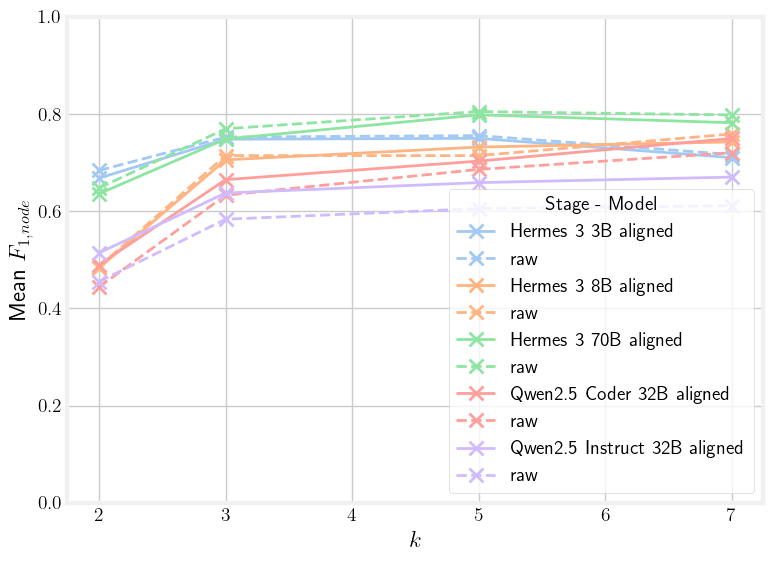

Plotting DBpedia - f1_score_rel - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting DBpedia - f1_score_rel - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting DBpedia - f1_score_rel - aligned - Hermes 3 8B
x solid #ffb482
Plotting DBpedia - f1_score_rel - raw - Hermes 3 8B
x dashed #ffb482
Plotting DBpedia - f1_score_rel - aligned - Hermes 3 70B
x solid #8de5a1
Plotting DBpedia - f1_score_rel - raw - Hermes 3 70B
x dashed #8de5a1
Plotting DBpedia - f1_score_rel - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting DBpedia - f1_score_rel - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting DBpedia - f1_score_rel - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting DBpedia - f1_score_rel - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


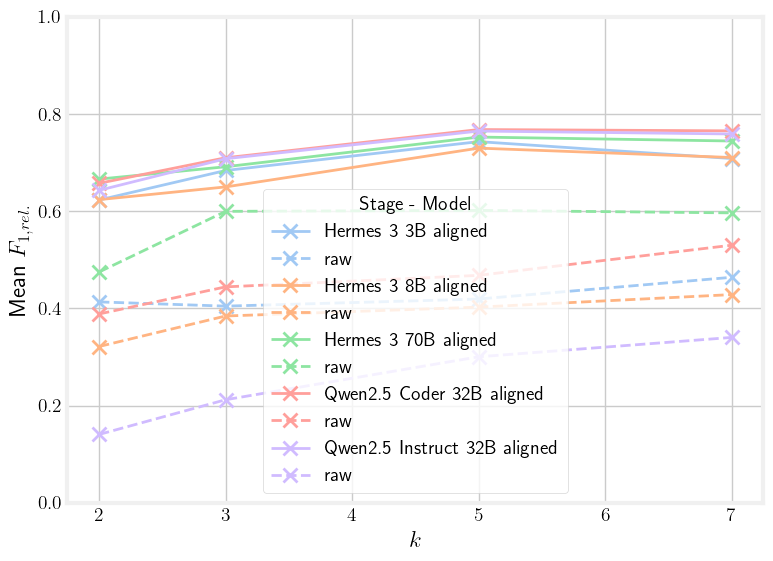

Plotting DBpedia - normed_ged - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting DBpedia - normed_ged - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting DBpedia - normed_ged - aligned - Hermes 3 8B
x solid #ffb482
Plotting DBpedia - normed_ged - raw - Hermes 3 8B
x dashed #ffb482
Plotting DBpedia - normed_ged - aligned - Hermes 3 70B
x solid #8de5a1
Plotting DBpedia - normed_ged - raw - Hermes 3 70B
x dashed #8de5a1
Plotting DBpedia - normed_ged - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting DBpedia - normed_ged - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting DBpedia - normed_ged - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting DBpedia - normed_ged - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


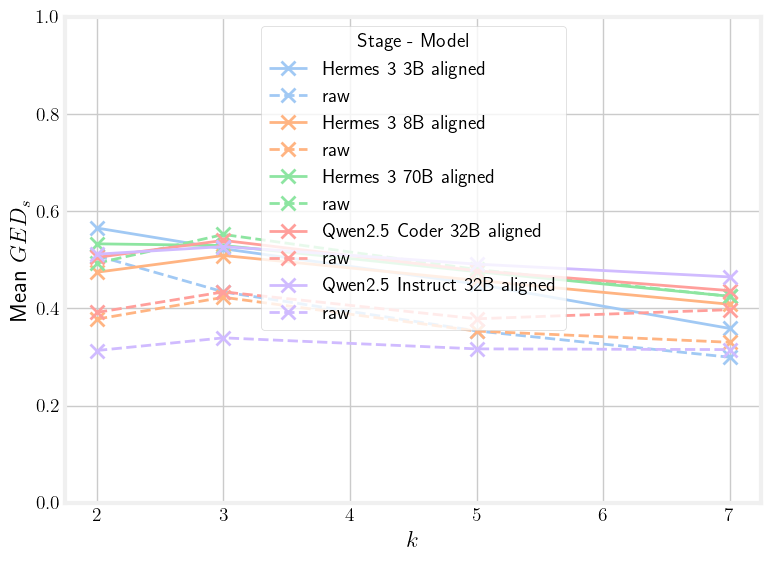

Plotting UniProt - f1_score - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting UniProt - f1_score - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting UniProt - f1_score - aligned - Hermes 3 8B
x solid #ffb482
Plotting UniProt - f1_score - raw - Hermes 3 8B
x dashed #ffb482
Plotting UniProt - f1_score - aligned - Hermes 3 70B
x solid #8de5a1
Plotting UniProt - f1_score - raw - Hermes 3 70B
x dashed #8de5a1
Plotting UniProt - f1_score - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting UniProt - f1_score - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting UniProt - f1_score - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting UniProt - f1_score - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


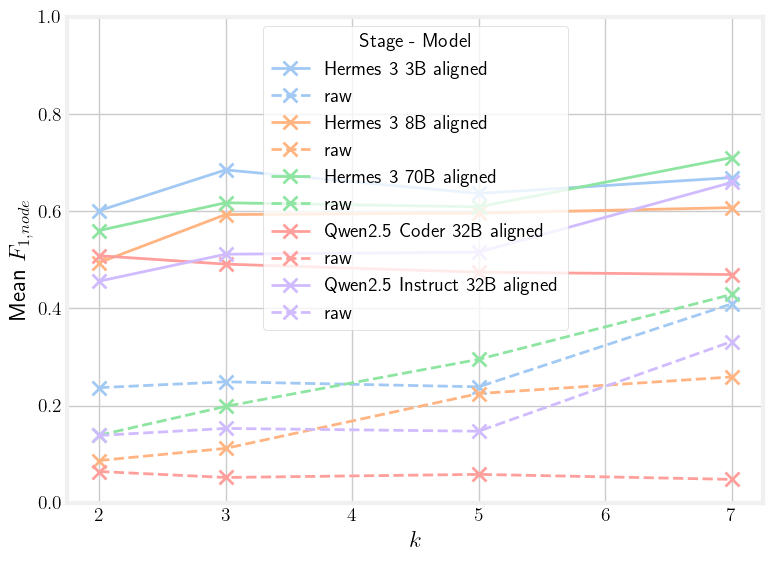

Plotting UniProt - f1_score_rel - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting UniProt - f1_score_rel - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting UniProt - f1_score_rel - aligned - Hermes 3 8B
x solid #ffb482
Plotting UniProt - f1_score_rel - raw - Hermes 3 8B
x dashed #ffb482
Plotting UniProt - f1_score_rel - aligned - Hermes 3 70B
x solid #8de5a1
Plotting UniProt - f1_score_rel - raw - Hermes 3 70B
x dashed #8de5a1
Plotting UniProt - f1_score_rel - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting UniProt - f1_score_rel - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting UniProt - f1_score_rel - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting UniProt - f1_score_rel - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


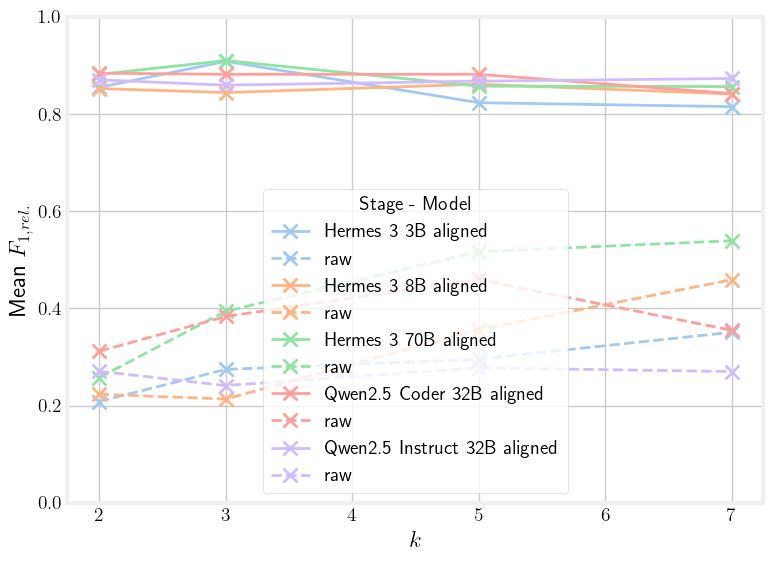

Plotting UniProt - normed_ged - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting UniProt - normed_ged - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting UniProt - normed_ged - aligned - Hermes 3 8B
x solid #ffb482
Plotting UniProt - normed_ged - raw - Hermes 3 8B
x dashed #ffb482
Plotting UniProt - normed_ged - aligned - Hermes 3 70B
x solid #8de5a1
Plotting UniProt - normed_ged - raw - Hermes 3 70B
x dashed #8de5a1
Plotting UniProt - normed_ged - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting UniProt - normed_ged - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting UniProt - normed_ged - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting UniProt - normed_ged - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


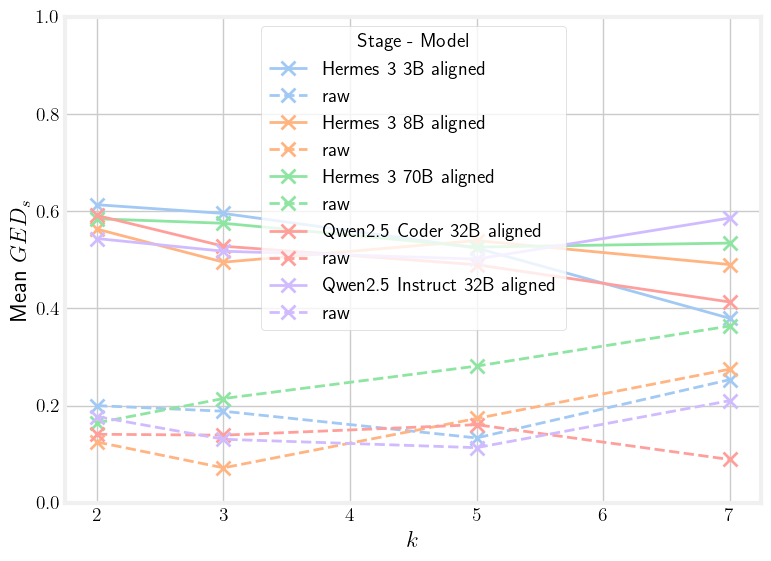

Plotting BTO - f1_score - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting BTO - f1_score - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting BTO - f1_score - aligned - Hermes 3 8B
x solid #ffb482
Plotting BTO - f1_score - raw - Hermes 3 8B
x dashed #ffb482
Plotting BTO - f1_score - aligned - Hermes 3 70B
x solid #8de5a1
Plotting BTO - f1_score - raw - Hermes 3 70B
x dashed #8de5a1
Plotting BTO - f1_score - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting BTO - f1_score - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting BTO - f1_score - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting BTO - f1_score - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


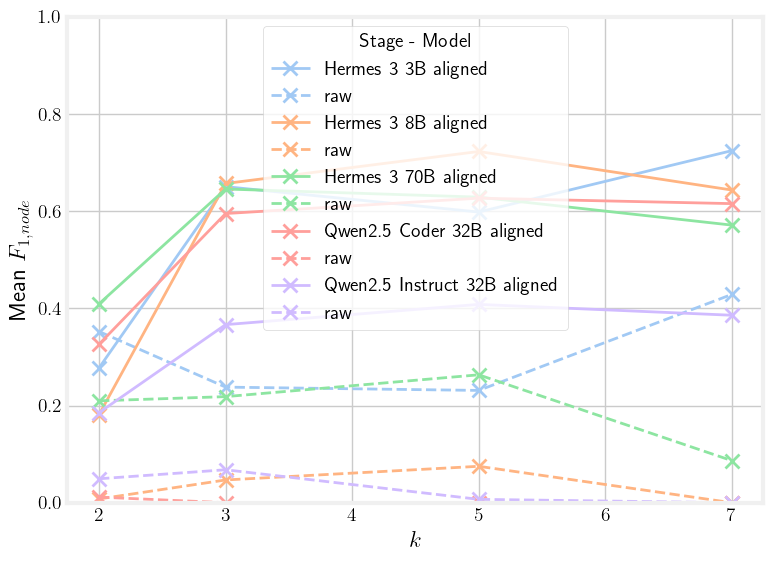

Plotting BTO - f1_score_rel - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting BTO - f1_score_rel - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting BTO - f1_score_rel - aligned - Hermes 3 8B
x solid #ffb482
Plotting BTO - f1_score_rel - raw - Hermes 3 8B
x dashed #ffb482
Plotting BTO - f1_score_rel - aligned - Hermes 3 70B
x solid #8de5a1
Plotting BTO - f1_score_rel - raw - Hermes 3 70B
x dashed #8de5a1
Plotting BTO - f1_score_rel - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting BTO - f1_score_rel - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting BTO - f1_score_rel - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting BTO - f1_score_rel - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


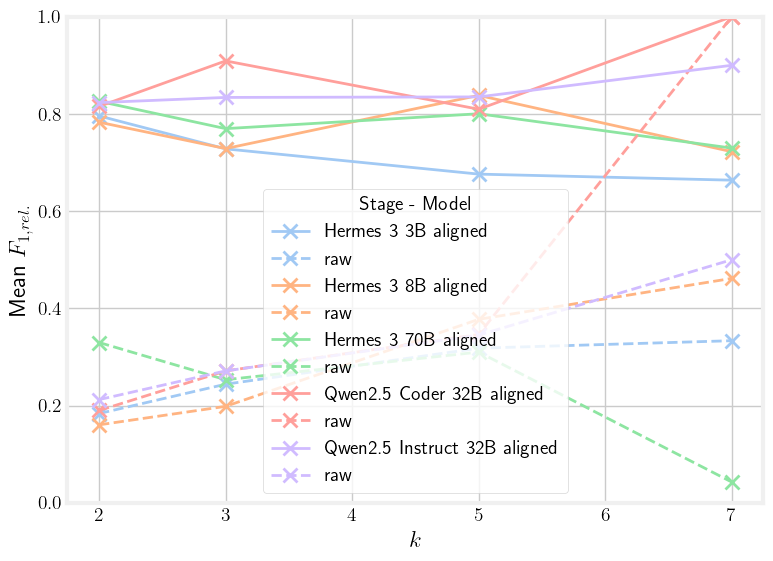

Plotting BTO - normed_ged - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting BTO - normed_ged - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting BTO - normed_ged - aligned - Hermes 3 8B
x solid #ffb482
Plotting BTO - normed_ged - raw - Hermes 3 8B
x dashed #ffb482
Plotting BTO - normed_ged - aligned - Hermes 3 70B
x solid #8de5a1
Plotting BTO - normed_ged - raw - Hermes 3 70B
x dashed #8de5a1
Plotting BTO - normed_ged - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting BTO - normed_ged - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting BTO - normed_ged - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting BTO - normed_ged - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


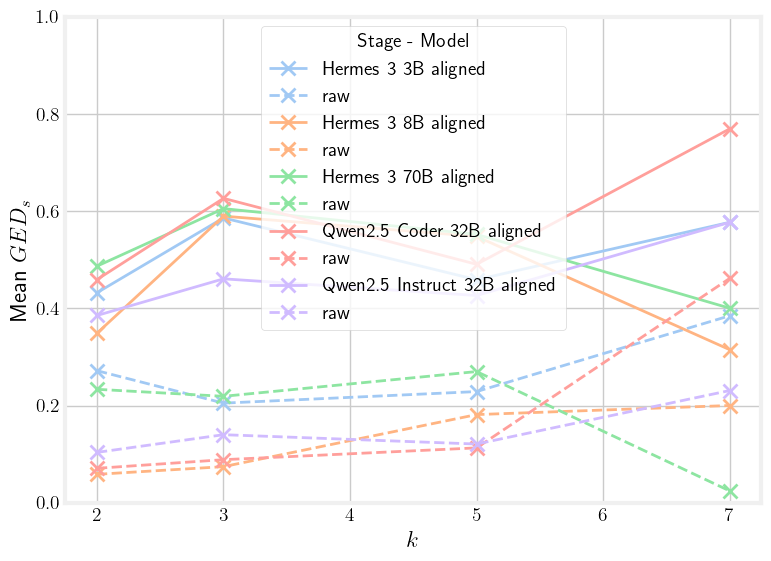

Plotting Yago - f1_score - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting Yago - f1_score - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting Yago - f1_score - aligned - Hermes 3 8B
x solid #ffb482
Plotting Yago - f1_score - raw - Hermes 3 8B
x dashed #ffb482
Plotting Yago - f1_score - aligned - Hermes 3 70B
x solid #8de5a1
Plotting Yago - f1_score - raw - Hermes 3 70B
x dashed #8de5a1
Plotting Yago - f1_score - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting Yago - f1_score - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting Yago - f1_score - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting Yago - f1_score - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


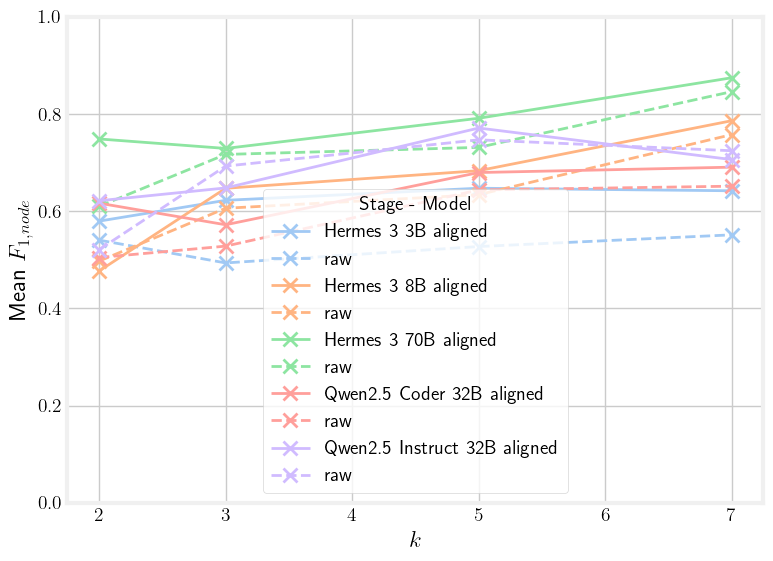

Plotting Yago - f1_score_rel - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting Yago - f1_score_rel - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting Yago - f1_score_rel - aligned - Hermes 3 8B
x solid #ffb482
Plotting Yago - f1_score_rel - raw - Hermes 3 8B
x dashed #ffb482
Plotting Yago - f1_score_rel - aligned - Hermes 3 70B
x solid #8de5a1
Plotting Yago - f1_score_rel - raw - Hermes 3 70B
x dashed #8de5a1
Plotting Yago - f1_score_rel - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting Yago - f1_score_rel - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting Yago - f1_score_rel - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting Yago - f1_score_rel - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


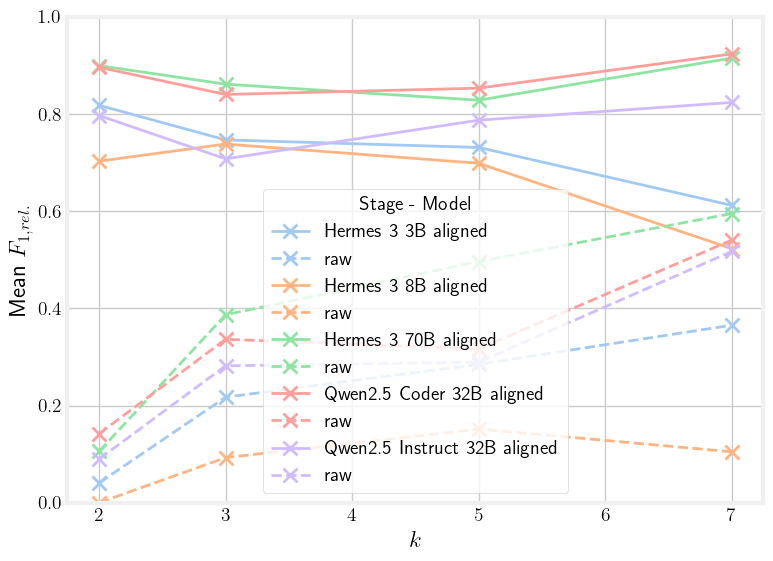

Plotting Yago - normed_ged - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting Yago - normed_ged - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting Yago - normed_ged - aligned - Hermes 3 8B
x solid #ffb482
Plotting Yago - normed_ged - raw - Hermes 3 8B
x dashed #ffb482
Plotting Yago - normed_ged - aligned - Hermes 3 70B
x solid #8de5a1
Plotting Yago - normed_ged - raw - Hermes 3 70B
x dashed #8de5a1
Plotting Yago - normed_ged - aligned - Qwen2.5 Coder 32B
x solid #ff9f9b
Plotting Yago - normed_ged - raw - Qwen2.5 Coder 32B
x dashed #ff9f9b
Plotting Yago - normed_ged - aligned - Qwen2.5 Instruct 32B
x solid #d0bbff
Plotting Yago - normed_ged - raw - Qwen2.5 Instruct 32B
x dashed #d0bbff


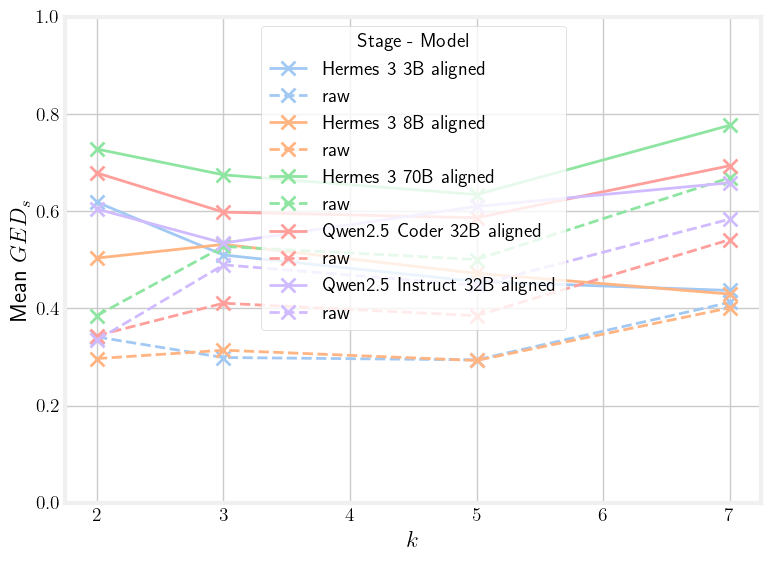

In [32]:
for dataset in grouped_dfs_raw.keys():
    df = grouped_dfs_raw[dataset].reset_index()
    df = df[(df["prompt_type"] == "one shot") & (df["n_nodes"] < 8)]
    metrics = [
        "f1_score",
        "f1_score_rel",
        "normed_ged",
    ]
    for metric in metrics:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        # fig.suptitle(f"{column_map[metric]} for {dataset}")
        patterns_stage = {
            "aligned": "solid",
            "raw": "dashed",
        }
        markers_stage = {
            "aligned": "x",
            "raw": "x",
            }
        for i, model in enumerate(chosen_models):
            for stage in df["stage"].unique():
                data = df[(df["stage"] == stage) & (df["model"] == model)]
                lower, median, upper, mean = tuple(
                    [
                        data[data["percentile"] == q][metric].to_numpy()
                        for q in quantiles + ["mean"]
                    ]
                )
                k = data[data["percentile"] == quantiles[1]]["n_nodes"].to_numpy()
                if not data.empty:
                    # ax.errorbar(
                    #     k,
                    #     median,
                    #     yerr=np.abs(np.stack([lower, upper]) - median),
                    #     label=f"{stage} - {model}",
                    #     marker=markers_stage[stage],
                    #     fillstyle="none",
                    #     markeredgecolor=palette[i],
                    #     # markeredgewidth=10,
                    #     # barsabove=
                    #     capsize=5,
                    #     linestyle=patterns_stage[stage],
                    #     color=palette[i],
                    #     ecolor=adjust_lightness(palette[i]),
                    # )
                    ax.plot(
                        k,
                        mean,
                        label=f"{model} {stage}" if stage == "aligned" else f"{stage}",
                        marker=markers_stage[stage],
                        fillstyle="none",
                        markeredgecolor=palette[i],
                        markersize=10,
                        markeredgewidth=2,
                        linewidth=2,
                        linestyle=patterns_stage[stage],
                        color=palette[i],
                    )
                    print(f"Plotting {dataset} - {metric} - {stage} - {model}")
                    print(markers_stage[stage], patterns_stage[stage], palette[i])

        # ax.set_title(f"Comparison of {dataset} across stages and prompt types")
        ax.set_xlabel("$k$")
        ax.set_ylabel(f"Mean {column_map[metric]}")
        ax.set_ylim(0, 1)
        tikzplotlib.save(
            f"figures/compare_{dataset}_{metric}.tex",
            extra_tikzpicture_parameters=[
                "scale=0.5",
                """every axis/.style={
                    legend pos=south west, 
                    legend style={
                font=\\small},
                    legend columns=2, 
                }""",
            ],
            axis_height="1.5\\textwidth",
            axis_width="2\\textwidth",
        )
        legend=ax.legend(title="Stage - Model")
        legend.set_ncols(2)
        tikzplotlib.save(
            f"figures/compare_{dataset}_{metric}_legend.tex",
            extra_tikzpicture_parameters=[
                "scale=0.5",
                """every axis/.style={
                    legend pos=south west, 
                    legend style={
                font=\\small},
                    legend columns=2, 
                }""",
            ],
            axis_height="1.5\\textwidth",
            axis_width="2\\textwidth",
        )
        
        
        plt.show()

In [33]:
np.stack([lower, upper]).shape

(2, 4)

In [34]:
upper-lower

array([0.66666667, 0.21666667, 0.47121212, 0.67307692])

In [35]:
(upper - lower) / 2

array([0.33333333, 0.10833333, 0.23560606, 0.33653846])